Copyright 2019 The Google Research Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Data Valuation using DVRL

 * Jinsung Yoon, Sercan O Arik, Tomas Pfister, "Data Valuation using Reinforcement Learning", arXiv preprint arXiv:1909.11671 (2019) - https://arxiv.org/abs/1909.11671
 
This notebook describes the user-guide of a data valuation application using "Data Valuation using Reinforcement Learning (DVRL)".

With a small validation set, DVRL can provide computationally highly efficient and high quality ranking of data values for the training dataset.

You need:

**Training / Validation / Testing sets** 
 * For data valuation, there is not constraint on the datasets. If you do not have a validation set, you can simply split a small portion of the training set as the validation set (we will use validation set to get performance feedback in DVRL).
 * If you have your own training / validation / testing sets, you should save those files as 'train.csv', 'valid.csv', 'test.csv' under './repo/data_files/' directory.
 * In this notebook, we use adult income dataset (https://archive.ics.uci.edu/ml/datasets/Adult) as an example.

##  Prerequisite

 * Download lightgbm package.
 * Clone https://github.com/google-research/google-research.git to the current directory.

In [1]:
# Uses pip3 to install necessary package (lightgbm)
!pip3 install lightgbm

# Resets the IPython kernel to import the installed package.
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

In [2]:
import os
from git import Repo

# Current working directory
repo_dir = os.getcwd() + '/repo'

if not os.path.exists(repo_dir):
    os.makedirs(repo_dir)

# Clones github repository
if not os.listdir(repo_dir):
    git_url = "https://github.com/google-research/google-research.git"
    Repo.clone_from(git_url, repo_dir)

## Necessary packages and functions call

 * data_loading: Data loader for tabular datasets.
 * data_preprocess: Data extraction and normalization.
 * dvrl_classification: Data valuation function for classification problem.
 * metrics: Evaluation metrics of the quality of data valuation in various metrics.

In [3]:
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import lightgbm

# Sets current directory
os.chdir(repo_dir)

from dvrl.data_loading import load_tabular_data, preprocess_data
from dvrl import dvrl
from dvrl.dvrl_metrics import remove_high_low

Using TensorFlow backend.


## Data loading

 * Create training, validation and testing sets and save them as train.csv, valid.csv, test.csv under './repo/data_files/ directory.
 * If you have your own train.csv, valid.csv, test.csv, just save them '.repo/data_files/' directory and you can skip this cell.

In [ ]:
# Data name: 'adult' in this notebook
data_name = 'adult'

# The number of training and validation samples
dict_no = dict()
dict_no['train'] = 1000
dict_no['valid'] = 400

# Loads data
_ = load_tabular_data(data_name, dict_no, 0.0)

print('Finished data loading.')

## Data preprocessing

 * Extract features and labels from train.csv, valid.csv, test.csv in './repo/data_files/' directory.
 * Normalize the features of training, validation, and testing sets.

In [5]:
# Normalization methods: either 'minmax' or 'standard'
normalization = 'minmax' 

# Extracts features and labels. Then, normalizes features.
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = \
preprocess_data(normalization, 'train.csv', 'valid.csv', 'test.csv')

print('Finished data preprocess.')

Finished data preprocess.


/usr/local/google/home/jinsungyoon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Run DVRL

1. **Input**: 

 * data valuator network parameters: Set network parameters of data valuator.
 * pred_model: The predictor model that maps output from the input. Any machine learning model (e.g. a neural network or ensemble decision tree) can be used as the predictor model, as long as it has fit, and predict (for regression)/predict_proba (for classification) as its subfunctions. Fit can be implemented using multiple backpropagation iterations.
 
 
2. **Output**:
 * data_valuator: Data value estimator function that can return the estimate data values for each sample.
 * dvrl_predictor: Function that predicts labels of the testing samples.
 * dve_out: Estimated data values of the entire training samples.

In [6]:
# Resets the graph
tf.reset_default_graph()
keras.backend.clear_session()
  
# Defines problem
problem = 'classification'

# Network parameters
parameters = dict()
parameters['hidden_dim'] = 100
parameters['comb_dim'] = 10
parameters['iterations'] = 2000
parameters['activation'] = tf.nn.relu
parameters['inner_iterations'] = 100
parameters['layer_number'] = 5
parameters['batch_size'] = 2000
parameters['batch_size_predictor'] = 256
parameters['learning_rate'] = 0.01

# Defines predictive model
pred_model = keras.models.Sequential()
pred_model.add(keras.layers.Dense(parameters['hidden_dim'], activation='relu'))
pred_model.add(keras.layers.Dense(parameters['hidden_dim'], activation='relu'))
pred_model.add(keras.layers.Dense(2, activation='softmax'))
pred_model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Sets checkpoint file name
checkpoint_file_name = './tmp/model.ckpt'

# Flags for using stochastic gradient descent / pre-trained model
flags = {'sgd': True, 'pretrain': False}

# Initializes DVRL
dvrl_class = dvrl.Dvrl(x_train, y_train, x_valid, y_valid,
                       problem, pred_model, parameters, checkpoint_file_name, flags)

# Trains DVRL
dvrl_class.train_dvrl('auc')

print('Finished dvrl training.')

# Estimates data values
dve_out = dvrl_class.data_valuator(x_train, y_train)

# Predicts with DVRL
y_test_hat = dvrl_class.dvrl_predictor(x_test)

print('Finished data valuation.')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



100%|██████████| 2000/2000 [32:09<00:00,  1.40it/s]


Finished dvrl training.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Finished data valuation.


## Evaluations

 * In this notebook, we use LightGBM as the predictor model in DVRL (but we can also replace it with another model for evaluation purposes).
 * Here, we use average accuracy as the performance metric but you can replace it with other metrics such as AUC.

### 1. Data valuation
DVRL learns the value of each training sample (individually) with a small validation set via reinforcement learning. Therefore, DVRL can provide the ranking of the training samples based on the estimated values of training samples.

* sorted_idx: Sorted training sample index based on the estimated data values by DVRL (decreasing order).
* sorted_x_train: Sorted training features based on the estimated data values by DVRL (decreasing order).
* sorted_y_train: Sorted training labels based on the estimated data values by DVRL (decreasing order).

In [7]:
# Data valuation
sorted_idx = np.argsort(-dve_out)
sorted_x_train = x_train[sorted_idx]
sorted_y_train = y_train[sorted_idx]

# The number of examples
n_exp = 5

# Indices of top n high valued samples
print('Indices of top ' + str(n_exp) + ' high valued samples: ' + str(sorted_idx[:n_exp]))
pd.DataFrame(data=sorted_x_train[:n_exp, :], index=range(n_exp), columns=col_names).head()

Indices of top 5 high valued samples: [499 597 598 603 604]


,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,WorkClass_ ?,WorkClass_ Federal-gov,WorkClass_ Local-gov,WorkClass_ Never-worked,...,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
0,0.589041,0.062189,0.800000,0.072981,0.0,0.602041,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.424658,0.131210,0.866667,0.150242,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.013699,0.114985,0.400000,0.000000,0.0,0.091837,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.164384,0.080705,0.533333,0.000000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.082192,0.116502,0.800000,0.000000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
# Indices of top n low valued samples
print('Indices of top ' + str(n_exp) + ' low valued samples: ' + str(sorted_idx[-n_exp:]))
pd.DataFrame(data=sorted_x_train[-n_exp:, :], index=range(n_exp), columns=col_names).head()

Indices of top 5 low valued samples: [330  94 770 191  16]


,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,WorkClass_ ?,WorkClass_ Federal-gov,WorkClass_ Local-gov,WorkClass_ Never-worked,...,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
0,0.602740,0.099137,0.400000,0.000000,0.0,0.316327,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.575342,0.172894,0.600000,0.000000,0.0,0.153061,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.095890,0.047316,0.600000,0.000000,0.0,0.295918,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.410959,0.099326,0.533333,0.140841,0.0,0.377551,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.260274,0.219071,0.733333,0.143441,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Removing high/low valued samples

Removing low value samples from the training dataset can improve the predictor model performance, especially in the cases where the training dataset contains corrupted samples. On the other
hand, removing high value samples, especially if the dataset is small, would decrease the performance significantly. Overall, the performance after removing high/low value samples is a strong
indicator for the quality of data valuation.

DVRL can rank the training data samples according to their estimated data value, and **by removing the low value samples we can improve performance, whereas removing the high value samples degrades the performance**.
 * Train predictive models after removing certain portions of high/low valued training samples.
 * Visualize the results using line graphs (set plot = True).
 * x-axis: Portions of removed samples.
 * y-axis: Prediction performance (accuracy).
 * Blue line: Removing low value data, Orange line: Removing high value data.

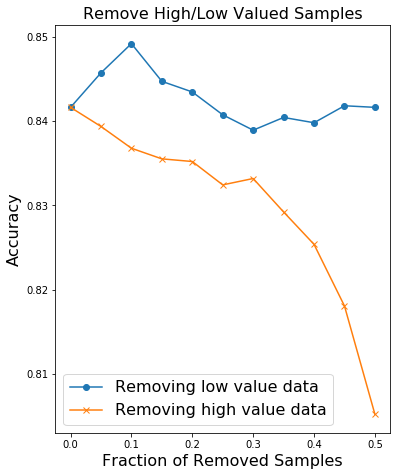

In [6]:
# Defines evaluation model
eval_model = lightgbm.LGBMClassifier()

# Evaluates performances after removing high/low valued samples
remove_high_low_performance = remove_high_low(dve_out, eval_model, x_train, y_train, 
                                              x_valid, y_valid, x_test, y_test, 'accuracy', plot = True)